In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [114]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")


# Importing Packages

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

# Reading The Data

In [116]:
Train_df = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
Train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [117]:
Test_df = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
Test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


# Explorative Data Analysis (EDA)

In [118]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [119]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


#### Both train and test data don't have null values and columns data types are correct.

In [120]:
Train_df.duplicated().sum() , Test_df.duplicated().sum()

(0, 0)

In [121]:
(Train_df['Calories'] < 0).any()


False

#### No Duplicates in the data

In [122]:
Train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [123]:
Train_df.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [124]:
Q1 = Train_df['Calories'].quantile(0.25)
Q3 = Train_df['Calories'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = Train_df[(Train_df['Calories'] < lower) | (Train_df['Calories'] > upper)]
outliers


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
10378,10378,male,75,180.0,79.0,30.0,120.0,41.2,295.0
10730,10730,male,60,205.0,114.0,30.0,119.0,40.8,295.0
14209,14209,male,64,185.0,90.0,29.0,127.0,40.9,295.0
19879,19879,male,72,186.0,93.0,30.0,125.0,41.0,295.0
20288,20288,male,75,178.0,76.0,29.0,120.0,40.9,295.0
...,...,...,...,...,...,...,...,...,...
715444,715444,male,72,191.0,97.0,28.0,120.0,40.9,295.0
716858,716858,male,70,182.0,86.0,29.0,120.0,40.9,295.0
718029,718029,male,33,198.0,96.0,29.0,121.0,40.9,300.0
732529,732529,male,57,195.0,97.0,29.0,120.0,41.1,314.0


#### Suspious data! very high consistant temperature, consistant duration, consistant calories and consistant sex! 

#### They are few samples compared to Train data size so I will drop them

In [125]:
Train_df = Train_df[(Train_df['Calories'] >= lower) & (Train_df['Calories'] <= upper)]

<Axes: xlabel='Sex', ylabel='Calories'>

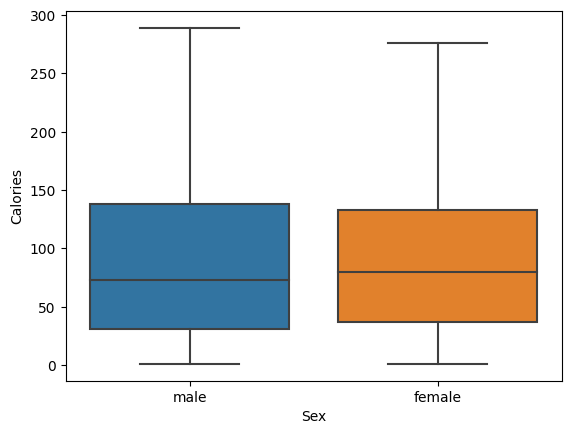

In [126]:
sns.boxplot(x='Sex', y='Calories', data=Train_df)

#### There is a difference between the distributions but not huge difference so including sex in the model may be useful

## Data Preprosessing

In [127]:
# Label Encoding
Train_df['Sex'] = Train_df['Sex'].map({'male': 0, 'female': 1})
Test_df['Sex'] = Test_df['Sex'].map({'male': 0, 'female': 1})


#### I am willing to try linear models but one hot enconding will result in the same single column of zeros and ones so there is no difference 

<Axes: >

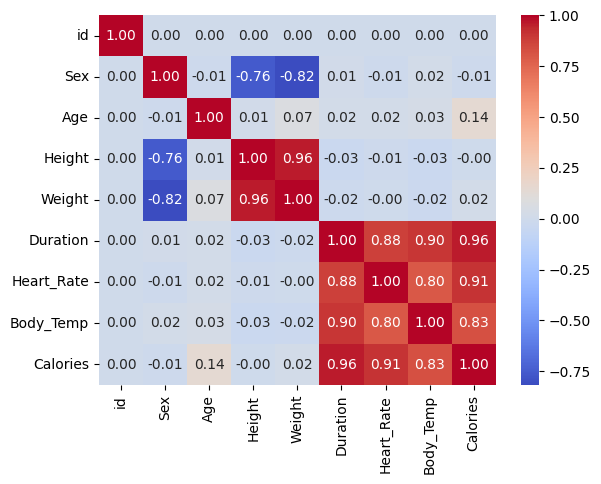

In [128]:
#Correlation Heatmap
sns.heatmap(Train_df.corr(),annot=True, fmt=".2f", cmap="coolwarm")

#### Height and weight are highly correlated so will replace them with one column Body Mass Index BMI = weight (kg) / (height (m))²


#### Duration, Heart_Rate and Body_temp are highly correlated, so initial guess tree based model will perform better and for regression I will apply regularization 

## Feature Engineering 

In [129]:
Train_df["BMI"] = Train_df["Weight"] / (Train_df["Height"] / 100) ** 2

Test_df["BMI"] = Test_df["Weight"] / (Test_df["Height"] / 100) ** 2

<Axes: >

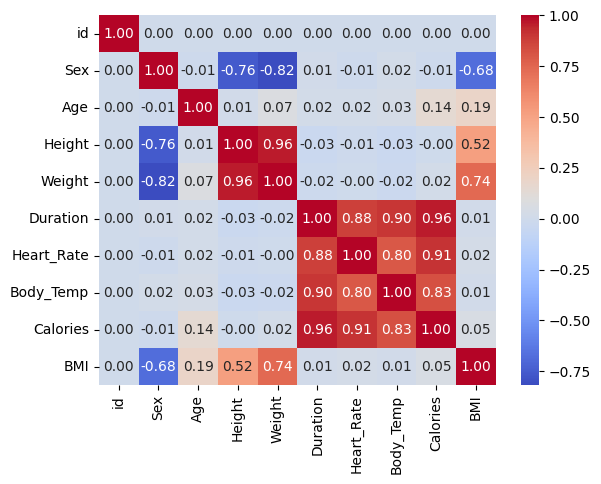

In [130]:
sns.heatmap(Train_df.corr(),annot=True, fmt=".2f", cmap="coolwarm")

#### Very low correlation may be due to the nonlinear equation, I will keep the feature but I will also keep the height and drop the weight. 

In [131]:
# Drop Height and Weight columns
Train_df = Train_df.drop(['Weight'], axis=1)
Test_df = Test_df.drop(['Weight'], axis=1)

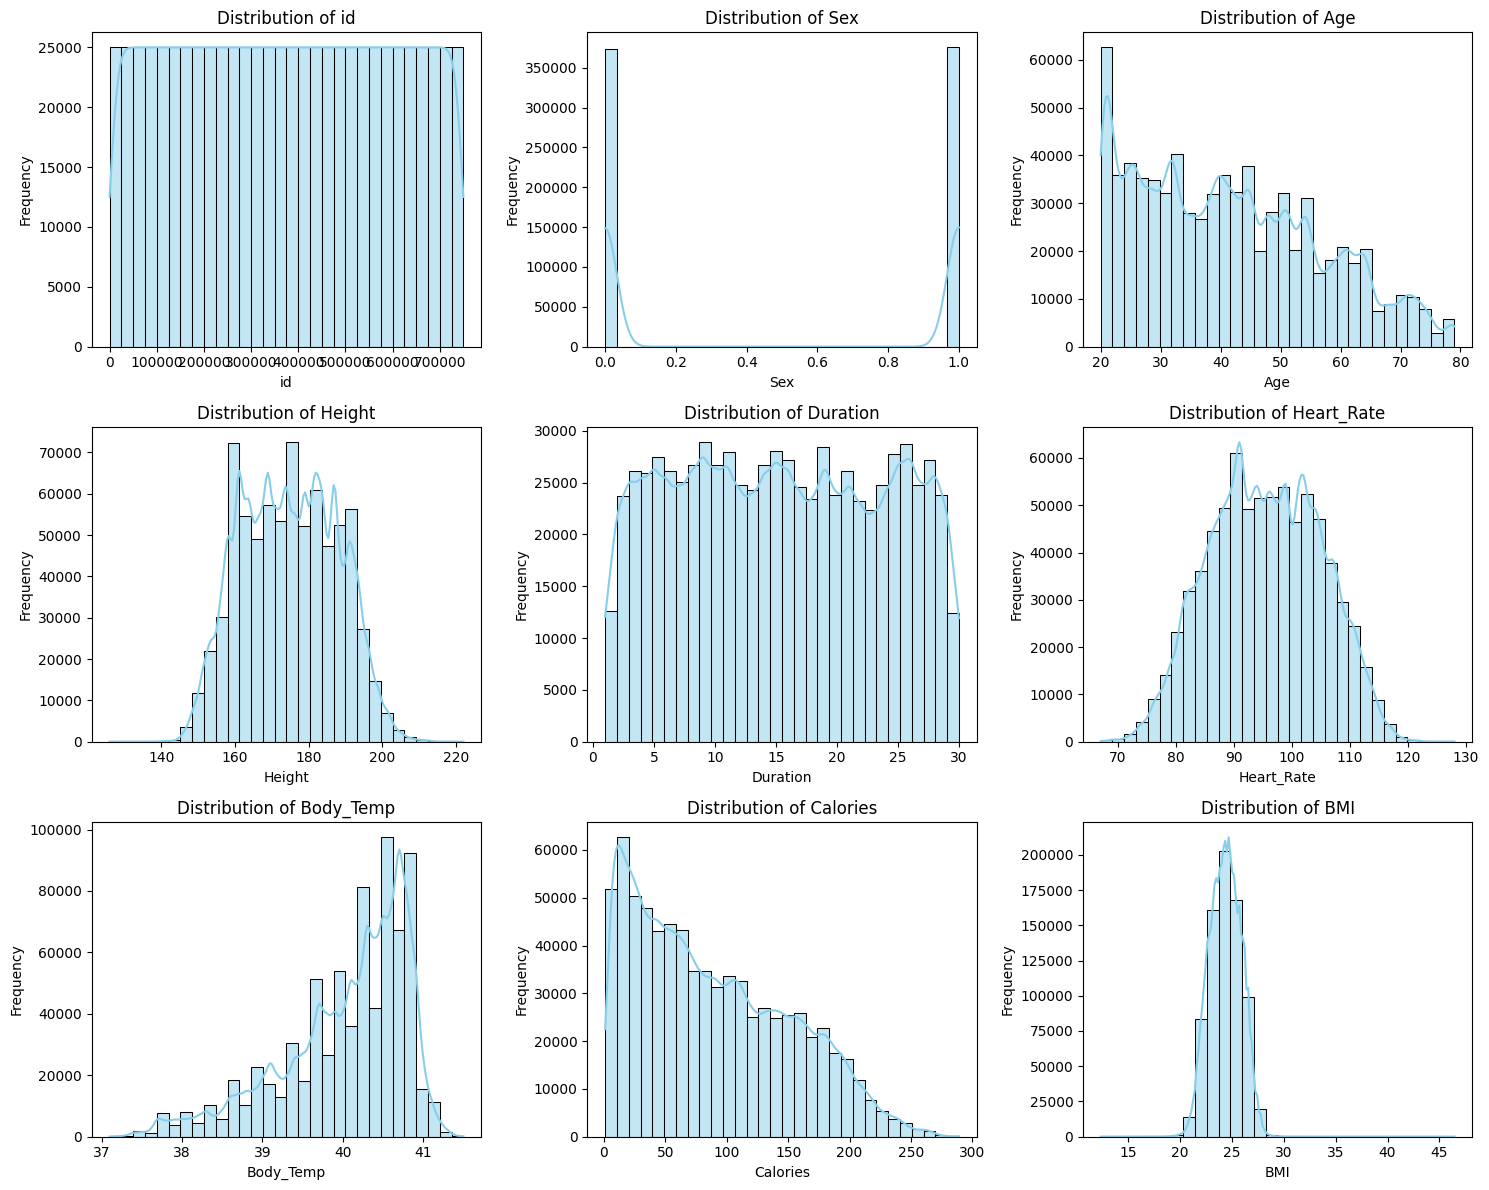

In [132]:
plt.figure(figsize=(15,  12))

for i, col in enumerate(Train_df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(Train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### * Feature Age is right skewed.
#### * Feature Body_Temp is left skewed.
#### * Target variable is right skewed but since I am willing to use RMSLE I won't take it's log  

In [133]:
Train_df['Age_Trans'] = np.log1p(Train_df['Age'])
Test_df['Age_Trans'] = np.log1p(Test_df['Age'])


Train_df['Body_Temp_trans'] = np.log1p(Train_df['Body_Temp'].max() - Train_df['Body_Temp'])
Test_df['Body_Temp_trans'] = np.log1p(Test_df['Body_Temp'].max() - Test_df['Body_Temp'])

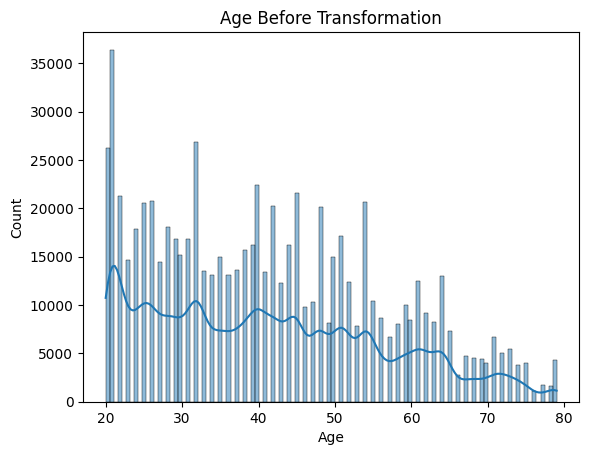

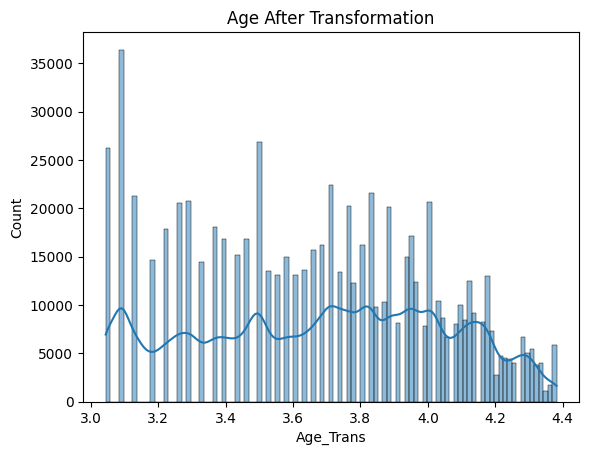

In [134]:

sns.histplot(Train_df['Age'], kde=True)
plt.title("Age Before Transformation")
plt.show()

sns.histplot(Train_df['Age_Trans'], kde=True)
plt.title("Age After Transformation")
plt.show()


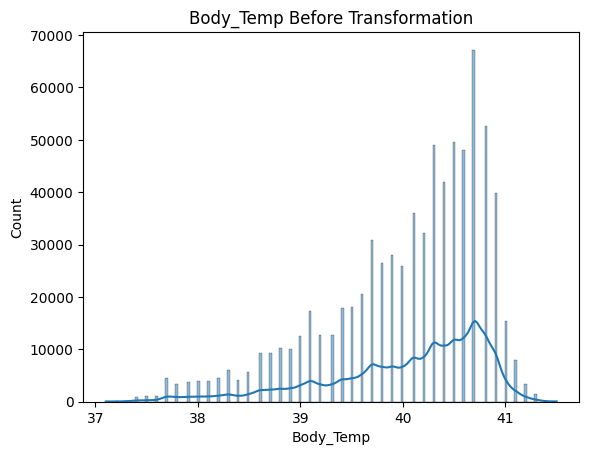

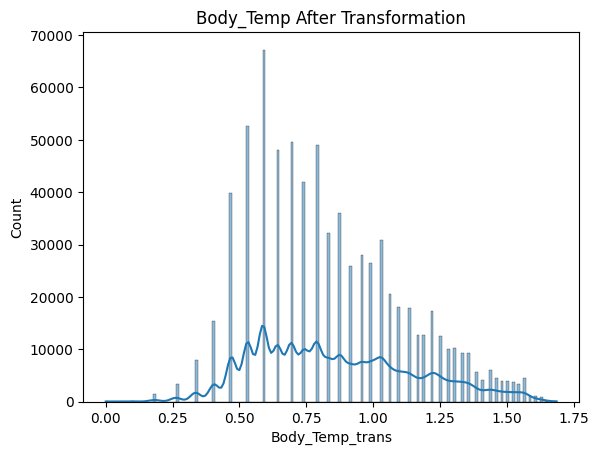

In [135]:
sns.histplot(Train_df['Body_Temp'], kde=True)
plt.title("Body_Temp Before Transformation")
plt.show()

sns.histplot(Train_df['Body_Temp_trans'], kde=True)
plt.title("Body_Temp After Transformation")
plt.show()

In [136]:
Train_df.drop(['Age', 'Body_Temp'],axis = 1, inplace = True)
Train_df.head()

,id,Sex,Height,Duration,Heart_Rate,Calories,BMI,Age_Trans,Body_Temp_trans
0,0,0,189.0,26.0,101.0,150.0,22.955684,3.610918,0.405465
1,1,1,163.0,8.0,85.0,34.0,22.582709,4.174387,1.029619
2,2,1,161.0,7.0,84.0,29.0,24.690405,3.951244,0.993252
3,3,0,192.0,25.0,105.0,140.0,24.414062,3.044522,0.587787
4,4,1,166.0,25.0,102.0,146.0,22.136740,3.663562,0.641854


In [137]:
Test_df.drop(['Age', 'Body_Temp'],axis = 1, inplace = True)           
Test_df.head()

,id,Sex,Height,Duration,Heart_Rate,BMI,Age_Trans,Body_Temp_trans
0,750000,0,177.0,7.0,87.0,25.854639,3.828641,0.993252
1,750001,0,200.0,20.0,101.0,24.250000,3.295837,0.693147
2,750002,1,188.0,16.0,102.0,24.049344,3.401197,0.741937
3,750003,1,172.0,20.0,107.0,24.675500,3.688879,0.641854
4,750004,1,173.0,16.0,94.0,22.386314,3.433987,0.693147


# Train/Validation Split

In [138]:
X = Train_df.drop(columns=['Calories', 'id'])
y = Train_df['Calories']

In [139]:
# reserving 20% of the training data to validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [140]:
X_train.shape , X_val.shape , y_train.shape , y_val.shape

((599888, 7), (149973, 7), (599888,), (149973,))

# Modeling 



## * Linear Regression

In [141]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## * lasso Regression 

In [142]:
lasso = Lasso(alpha=0.05) # Alpha is the regulariztion strength
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

#### Trying larger values for Alpha increased the msle error and trying less values than 0.05 didn't chane the error so I concluded that eliminating feartures is not helpful maybe reducing their coefficent will do better so I will give Ridge regularizagion a try

## * Ridge Regression 

In [143]:
ridge = Ridge(alpha=0.5) 
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

#### Tuining Ridge regression gave me no result better than linear regression and since the data has many features that are correlated with each others and other features which has very low linear correlation with the target, maybe tree based models will do better.

## * Random Forest

In [144]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [145]:
rf.get_params()                        

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [146]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define distributions instead of fixed lists
# param_dist = {
#     'n_estimators': randint(100, 300),        # integers between 100 and 300
#     'max_depth': [10, 20, None],
#     'min_samples_split': randint(2, 10),
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=RandomForestRegressor(),
#     param_distributions=param_dist,
#     n_iter=10,  # Number of random combinations to try
#     scoring='neg_mean_squared_log_error',
#     cv=3,
#     random_state=42,
#     n_jobs=-1  # Use all cores for faster processing

# # Run search
# random_search.fit(X_train, y_train)

# # Best model
# best_model = random_search.best_estimator_




In [147]:
# best_model.get_params()                        

In [148]:

rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, max_features=0.7, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

## * XGBoost

In [149]:
from xgboost import XGBRegressor
xgb = XGBRegressor( n_jobs=-1)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [150]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [151]:
xgb_tuned = XGBRegressor(
    n_estimators=900,        # More boosting rounds
    max_depth=10,             # deeper trees
    learning_rate=0.03,      # Lower for better generalization
    subsample=0.95,          # More randomness
    colsample_bytree=0.95,   # More randomness
    min_child_weight=2,      # Slightly more flexible
    reg_alpha=0.05,           # L1 regularization
    reg_lambda=1,          # L2 regularization
    random_state=42,
    n_jobs=-1
)

xgb_tuned.fit(X_train , y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

# Evaluation

In [152]:
def evaluate(model):
    y_pred = model.predict(X_val)
    y_pred = np.clip(y_pred, 0, None)  # Replace negatives with 0
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    print(f"{model.__class__.__name__} RMSlE: {rmsle:.5f}")

In [153]:
evaluate(lr) 
evaluate(lasso)
evaluate(ridge)
evaluate(rf)

LinearRegression RMSlE: 0.59062
Lasso RMSlE: 0.59438
Ridge RMSlE: 0.59062
RandomForestRegressor RMSlE: 0.06381


In [154]:
# evaluate(best_model)

In [155]:
evaluate(rf_tuned)

RandomForestRegressor RMSlE: 0.06137


In [156]:
evaluate(xgb_tuned)

XGBRegressor RMSlE: 0.06035


# Testing and Submission 

In [160]:
Test_df.head()

,id,Sex,Height,Duration,Heart_Rate,BMI,Age_Trans,Body_Temp_trans
0,750000,0,177.0,7.0,87.0,25.854639,3.828641,0.993252
1,750001,0,200.0,20.0,101.0,24.250000,3.295837,0.693147
2,750002,1,188.0,16.0,102.0,24.049344,3.401197,0.741937
3,750003,1,172.0,20.0,107.0,24.675500,3.688879,0.641854
4,750004,1,173.0,16.0,94.0,22.386314,3.433987,0.693147


In [162]:
#Predicting calories for the test data
X_test = Test_df.drop('id', axis = 1)
y_pred_test = xgb_tuned.predict(X_test)
y_pred_test = np.clip(y_pred_test, 0, None)  # Replace negatives with 0
y_pred_test.shape

(250000,)

In [163]:
#preparing submission file
submission = pd.DataFrame({
    'id': Test_df['id'],
    'Calories': y_pred_test
})

submission.head()

,id,Calories
0,750000,26.727285
1,750001,108.880524
2,750002,87.545456
3,750003,126.362480
4,750004,76.544174


In [164]:
# Save it to a CSV file
submission.to_csv('submission.csv', index=False)